In [27]:
import numpy as np
import pandas as pd
from cross_val_custom import cross_validation_score_statement, cross_validation_score_fit_subset
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error

Let's load Boston dataset and add 20 outliers

In [30]:
X,y = load_boston(return_X_y=True)
np.random.seed(0)
for i in range(20):
    y[np.random.randint(0,y.shape[0]+1)] += 50

Now we're making out-of-fold predictions of target

Populating the interactive namespace from numpy and matplotlib


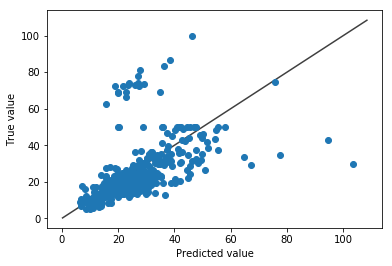

In [39]:
%pylab inline
y_pred = cross_val_predict(estimator=GradientBoostingRegressor(random_state=0,n_estimators=100),X=X,y=y,cv=5)
fig, ax = plt.subplots()
ax.scatter(y=y,x=y_pred)
ax.set_xlabel('Predicted value')
ax.set_ylabel('True value')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

The majority of points is not far from the y=x line. However we see our outliers in the left top corner (since we added 50 to some objects' targets). In the right bottom corner we see the abnormal high predictions caused by the presence of the outliers in the dataset.
If we will use cross-validation now for tuning the parameters of our model - we will be mostly trying to fix these 'bad' points instead of improving quality for the majority of 'normal' objects. This is especially the case when the metric is sensitive to outliers (MSE, R2, ...)

It might be better to improve accuracy on the 'normal' objects situated not so far from y=x. These objects are the majority. We can't just drop outliers since we won't be able to detect them in the test dataset when target is unknown.
The approach can be like this. We say: "OK, we can't improve outliers much, let's try to improve quality on the 'normal' objects".
During cross-validation on each iteration we use all objects to perform fit, but use only normal objects for scoring.
We define objects with absolute error > 25 as outliers and do not calculate score for them (statement=~outliers_mask).

In [41]:
outliers_mask = np.absolute(y-y_pred)>25
cross_validation_score_statement(estimator=GradientBoostingRegressor(random_state=0),X=pd.DataFrame(X),y=pd.Series(y),n_splits=5,
                                 statement=~outliers_mask,scoring=mean_absolute_error)

array([ 3.69233287,  3.61079391,  4.13051729,  3.83593642,  3.92674495])

In some cases dropping outliers from the train can increase accuracy on test. Now are oing this: we fit only 'normal' objects, but predict and score all objects.

In [42]:
cross_validation_score_fit_subset(estimator=GradientBoostingRegressor(random_state=0),X=pd.DataFrame(X),y=pd.Series(y),n_splits=5,
                                  statement=~outliers_mask,scoring=mean_absolute_error)

array([ 4.21334503,  4.06242579,  4.96166443,  4.31248986,  4.16140199])

Note, that the output of cross_validation_score_statement is not an assessment of your score on real test data. It is just a measure of how good is the particular estimator predicting 'normal' objects. The only use of this function is for comparing different machine learning pipelines.
The cross_validation_score_fit_subset is an assessment of the score on real test data while it scores every object including outliers. By this function you can check if there is a sense to drop outliers from train.